# Recommender une orientation 

In [2]:

import pandas as pd
import pyodbc

# Connexion à la base de données
server = 'LAPTOP-VAILS20L'         
database = 'DW_PI'                
username = 'sa'                   
password = 'sa123'                 
driver = '{SQL Server}'            

# Connexion à SQL Server
conn = pyodbc.connect(
    f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}'
)

# Charger les données
query_fact = """
SELECT TOP 1000 
    [Candidature_Pk], [Dossier_Pk], [Candidat_pk], [Gouv_PK], [Pays_Pk], [Diplome_Pk],
    [Concours_Pk], [Bac_Pk], [Date_Pk1], [Date_Pk2], [Date_Pk3], [Date_Pk4], [Date_Pk5],
    [score_final], [moy_bac_et], [Admission]
FROM [DW_PI].[dbo].[fact_date2]
"""
query_diplome = """
SELECT TOP 1000 
    [Diplome_Pk], [Mention], [Diplome], [Faculte], [annee_souhaite], [Cin], [Specialite]
FROM [DW_PI].[dbo].[Dim_Diplome]
"""
query_bac = """
SELECT TOP 1000 
    [Bac_Pk], [nature_bac], [bac]
FROM [DW_PI].[dbo].[Dim_Bac]
"""

fact_df = pd.read_sql(query_fact, conn)
diplome_df = pd.read_sql(query_diplome, conn)
bac_df = pd.read_sql(query_bac, conn)

# Fusionner les données (fact_df avec bac_df et diplome_df)
df = fact_df.merge(bac_df, on='Bac_Pk', how='left')
df = df.merge(diplome_df, on='Diplome_Pk', how='left')

# === Supprimer les lignes inutilisables ===
df = df[df['Diplome_Pk'] != 0]
df = df[df['Specialite'].notna()]
df = df[df['nature_bac'].isin(['MATH', 'INFO', 'TECH', 'SCEXP'])]
# Ajouter la colonne "Orientation" en fonction de la nature du bac
def assign_orientation(nature_bac):
    if nature_bac in ['MATH', 'INFO','SCEXP']:
        return 'TIC'
    elif nature_bac == 'TECH':
        return 'Genie civil'
    else:
        return 'refus'  # Pour les autres cas (LETT, SPORT, ECOG qui sont à ignorer)

df['Orientation'] = df['nature_bac'].apply(assign_orientation)

# Filtrer les données pour ne garder que les valeurs pertinentes
df = df[df['Orientation'] != 'Autre']


C:\Users\souha\AppData\Local\Temp\ipykernel_7152\87884678.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fact_df = pd.read_sql(query_fact, conn)
C:\Users\souha\AppData\Local\Temp\ipykernel_7152\87884678.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diplome_df = pd.read_sql(query_diplome, conn)
C:\Users\souha\AppData\Local\Temp\ipykernel_7152\87884678.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bac_df = pd.read_sql(query_bac, conn)


In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Normaliser les variables numériques
scaler = StandardScaler()
df[['score_final', 'moy_bac_et']] = scaler.fit_transform(df[['score_final', 'moy_bac_et']])
# Encoder nature_bac
le_bac = LabelEncoder()
df['Nature_bac_encoded'] = le_bac.fit_transform(df['nature_bac'])

# Encoder les variables catégorielles
le = LabelEncoder()
df['Orientation_encoded'] = le.fit_transform(df['Orientation'])
df['Specialite_encoded'] = le.fit_transform(df['Specialite'])

# Afficher le DataFrame pré-traité
df.head(50)


,Candidature_Pk,Dossier_Pk,Candidat_pk,Gouv_PK,Pays_Pk,Diplome_Pk,Concours_Pk,Bac_Pk,Date_Pk1,Date_Pk2,...,Mention,Diplome,Faculte,annee_souhaite,Cin,Specialite,Orientation,Nature_bac_encoded,Orientation_encoded,Specialite_encoded
508,1815,1815,1189,10,32,81,45,11,20220721,20200801,...,جيد,licence appliquée,ISET,3A,1505697,informatique,TIC,1,1,3
512,1818,1818,1191,5,32,82,37,11,20220726,20230811,...,جيد جداً,licence appliquée,ISET,3A,1505700,informatique,TIC,1,1,3
513,1819,1819,1183,16,32,75,37,10,20220724,20220807,...,ممتاز,licence appliquée,ISET,3A,1505701,informatique,Genie civil,3,0,3
519,1822,1822,1186,4,32,78,46,10,20220725,20200813,...,جيد جداً,licence appliquée,ISET,3A,1505704,informatique,Genie civil,3,0,3
527,1827,1827,1197,14,32,88,36,11,20220726,20220805,...,جيد,licence appliquée,ISET,3A,1505708,informatique,TIC,1,1,3
532,1832,1832,1193,23,32,84,40,6,20220716,20230805,...,ممتاز,licence appliquée,ISET,3A,1505713,informatique,TIC,0,1,3
533,1834,1862,1187,17,32,79,36,6,20220726,20220806,...,مقبول,licence appliquée,ISET,3A,1505715,informatique,TIC,0,1,3
540,1839,1836,1199,5,32,90,46,21,20220717,20200802,...,ممتاز,licence appliquée,ISET,3A,1505716,informatique,TIC,2,1,3
601,1873,1873,1265,2,32,62,36,11,20220718,20220808,...,ممتاز,MASTER,INSAT,4éme,1505750,Technologies de l'information,TIC,1,1,2
619,1885,1885,1267,17,32,64,37,11,20220729,20220811,...,جيد,MASTER,INSAT,4éme,1505761,Sciences informatiques,TIC,1,1,1


### K-Means

C:\Users\souha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\souha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\souha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\souha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

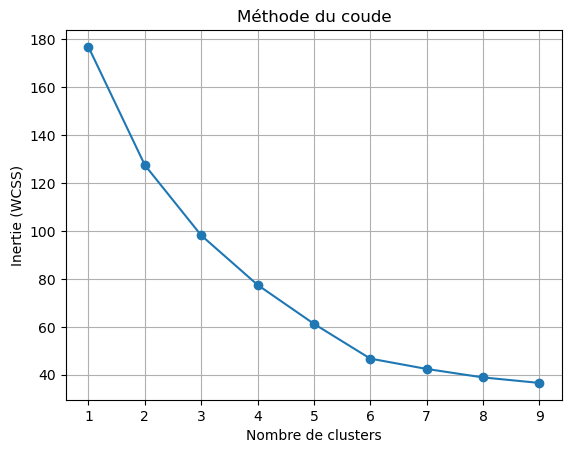

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# === Préparation des features ===
features = ['score_final', 'moy_bac_et', 'Specialite_encoded' , 'Nature_bac_encoded' ]
X = df[features]

# === Méthode du coude pour déterminer le nombre optimal de clusters ===
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss, marker='o')
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie (WCSS)")
plt.grid()
plt.show()


In [5]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)


C:\Users\souha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\souha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Analyser les clusters

In [6]:
# Voir comment se répartissent les orientations dans les clusters
cluster_summary = df.groupby('Cluster')['Orientation'].value_counts(normalize=True)
print(cluster_summary)


Cluster  Orientation
0        TIC            0.900000
         Genie civil    0.100000
1        TIC            1.000000
2        TIC            0.545455
         Genie civil    0.454545
Name: proportion, dtype: float64


##  Système de recommandation  (à partir des clusters)

In [7]:
def recommander_orientation(score, moy_bac, specialite_str, nature_bac_str):
    # transformer les valeurs du candidat
    score_scaled = scaler.transform([[score, moy_bac]])[0]
    specialite_encoded = le.transform([specialite_str])[0]
    nature_bac_encoded = le_bac.transform([nature_bac_str])[0]
    X_input = [[score_scaled[0], score_scaled[1], specialite_encoded,nature_bac_encoded ]]
    cluster = kmeans.predict(X_input)[0]
    
    # Prendre l'orientation la plus fréquente dans ce cluster
    orientation_recommandée = df[df['Cluster'] == cluster]['Orientation'].mode()[0]
    return orientation_recommandée


In [8]:
recommander_orientation(score=15.0, moy_bac=14.5, specialite_str="informatique", nature_bac_str='INFO' )


C:\Users\souha\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\souha\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


'TIC'

## IA et Deep learning

In [9]:
from sklearn.model_selection import train_test_split

# Variables d'entrée et cible
X = df[['score_final', 'moy_bac_et', 'Specialite_encoded', 'Nature_bac_encoded']].values
y = df['Orientation_encoded'].values

# Séparation des données en train et test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Création du modèle de réseau de neurones

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Charger ton DataFrame 'df' ici

# Séparation des variables d'entrée (features) et cible
X = df[['score_final', 'moy_bac_et', 'Specialite_encoded', 'Nature_bac_encoded']].values
y = df['Orientation_encoded'].values

# Séparer les données en train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir y en one-hot encoding
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Infos des dimensions pour les variables catégorielles
embedding_info = {
    'Specialite_encoded': len(df['Specialite_encoded'].unique()),
    'Nature_bac_encoded': len(df['Nature_bac_encoded'].unique())
}

# Inputs pour chaque variable (score_final et moy_bac_et sont numériques)
input_score_final = Input(shape=(1,))
input_moy_bac_et = Input(shape=(1,))
input_specialite = Input(shape=(1,))
input_nature_bac = Input(shape=(1,))

# Embeddings pour les variables catégorielles
embed_specialite = Embedding(input_dim=embedding_info['Specialite_encoded'], output_dim=4)(input_specialite)
embed_nature_bac = Embedding(input_dim=embedding_info['Nature_bac_encoded'], output_dim=4)(input_nature_bac)

# Flatten les embeddings
flat_specialite = Flatten()(embed_specialite)
flat_nature_bac = Flatten()(embed_nature_bac)

# Concatenate toutes les variables
concat = Concatenate()([input_score_final, input_moy_bac_et, flat_specialite, flat_nature_bac])

# Réseau de neurones
x = Dense(128, activation='relu')(concat)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(y_train_cat.shape[1], activation='softmax')(x)

# Création du modèle
model = Model(inputs=[input_score_final, input_moy_bac_et, input_specialite, input_nature_bac], outputs=output)

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_8 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 4)              │              16 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 4)              │              16 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_6 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 4)                 │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 4)                 │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 10)                │               0 │ input_layer_5[0][0],       │
│                               │                           │                 │ input_layer_6[0][0],       │
│                               │                           │                 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 128)               │           1,408 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 128)               │               0 │ dense_16[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (None, 64)                │           8,256 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 64)                │               0 │ dense_17[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 2)                 │             130 │ dropout_7[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,826 (38.38 KB)

 Trainable params: 9,826 (38.38 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
print(X_train.shape)  # Devrait être (nombre_d'échantillons, 4)
print(y_train_cat.shape)  # Devrait être (nombre_d'échantillons, nombre_de_classes)


(31, 4)
(31, 2)


In [47]:
pip install --upgrade tensorflow


  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-win_amd64.whl.metadata (22 kB)
Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl (375.9 MB)
Using cached ml_dtypes-0.5.1-cp311-cp311-win_amd64.whl (209 kB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling tensorflow-2.16.2:
      Successfully uninstalled tensorflow-2.16.2
  Rolling back uninstall of tensorflow
  Moving to c:\users\souha\anaconda3\lib\

  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\souha\\anaconda3\\Lib\\site-packages\\tensorflow\\compiler\\mlir\\quantization\\tensorflow\\python\\pywrap_function_lib.pyd'
Consider using the `--user` option or check the permissions.



In [54]:
pip install --upgrade --user tensorflow


  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl (375.9 MB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [55]:
# Vérifier la forme des entrées et des cibles
print(X_train.shape)  # Devrait être (31, 4)
print(y_train_cat.shape)  # Devrait être (31, 2)

# Préparer les entrées comme une liste d'entrées distinctes
inputs = [X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3]]

# Entrainer le modèle
history = model.fit(
    inputs,  # Passer les données d'entrée sous forme de liste
    y_train_cat,  # Cibles
    epochs=30,
    batch_size=32,
    validation_data=([X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3]], y_test_cat),  # Validation explicite
    verbose=2
)


(31, 4)
(31, 2)
Epoch 1/30


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.